In [1]:
# auto reload
%load_ext autoreload
%autoreload 2

# 2Stage

In [15]:
import pandas as pd

# data
img_width_ratio = 1.0
img_height_ratio = 1.0
annotation_path = "../Detecto/labels_balanced.csv"
image_dir = '../datasets/centered_cells/whole_set/'
pad = False
idx2name = {
    0: 'LY',
    1: 'RBC',
    2: 'PLT',
    3: 'EO',
    4: 'MO',
    5: 'BNE',
    6: 'SEN',
    7: 'BA'
            }
name2idx = {v: k for k, v in idx2name.items()}

In [3]:
import torch
from torch.utils.data import DataLoader
from torch_rcnn_try.data_train import ObjectDetectionDataset, collate_fn
# load data
od_dataset = ObjectDetectionDataset(annotation_path, image_dir, (img_height_ratio, img_width_ratio), name2idx, pad=False)

od_dataloader = DataLoader(od_dataset, collate_fn=collate_fn, batch_size=2)
#split data into train and val
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(od_dataset, [0.8, 0.2], generator=generator1)
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=2)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)

In [4]:
from app.two_stage_detector import TwoStageDetector

detector = TwoStageDetector('yolo')

YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-2.0.1 CPU

Fusing layers... 
Model summary: 212 layers, 20881221 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


In [5]:
detections = []

In [6]:
targets = []

In [7]:
for image_batch, targets_batch in val_dataloader:
    outputs = detector.detect(image_batch, remove_bottom=False, small_image=False)
    detections.extend(outputs)
    targets.extend(targets_batch)

Running inference on 2 splits
Running inference on batch 1/4
max value: 1.0
min value: 0.0
Example bbox: tensor([[106.47042, 101.91223, 252.19141, 256.14923]])
Running inference on batch 3/4
max value: 1.0
min value: 0.0
Example bbox: tensor([], size=(0, 4))
Done adjusting boxes
Example box: tensor([[106.47042, 101.91223, 252.19141, 256.14923]])
Reconstructing boxes
Done reconstructing boxes
Running inference on 2 splits
Running inference on batch 1/4
max value: 1.0
min value: 0.0
Example bbox: tensor([[ 53.12952,  50.95686, 125.99355, 128.07256]])
Running inference on batch 3/4
max value: 1.0
min value: 0.0
Example bbox: tensor([], size=(0, 4))
Done adjusting boxes
Example box: tensor([[106.25903, 101.91373, 251.98711, 256.14511]])
Reconstructing boxes
Done reconstructing boxes
Running inference on 2 splits
Running inference on batch 1/4
max value: 1.0
min value: 0.0
Example bbox: tensor([[26.35638, 25.55588, 62.66246, 64.23013]])
Running inference on batch 3/4
max value: 1.0
min valu

In [13]:
for i, dl in enumerate(det_labels):
    det_labels[i] = [name2idx[name] for name in dl]

In [9]:
import torch
import torchvision

def match_predictions_to_ground_truth(pred_boxes, pred_labels, gt_boxes, gt_labels, iou_threshold=0.5):
    # Compute the IoU between each prediction and ground truth
    iou_matrix = torchvision.ops.box_iou(pred_boxes, gt_boxes)

    # Threshold the IoU to get a binary matrix indicating matches
    matches = iou_matrix > iou_threshold

    # Get the indices of the matched predictions and ground truth
    matched_pred_indices, matched_gt_indices = torch.where(matches)

    # Filter the predictions and ground truth to get only the matched ones
    matched_pred_boxes = pred_boxes[matched_pred_indices]
    matched_pred_labels = pred_labels[matched_pred_indices]
    matched_gt_boxes = gt_boxes[matched_gt_indices]
    matched_gt_labels = gt_labels[matched_gt_indices]

    # Check if the labels of the matched predictions and ground truth are the same
    label_matches = matched_pred_labels == matched_gt_labels

    # Only keep the matched predictions and ground truth where the labels are also the same
    matched_pred_boxes = matched_pred_boxes[label_matches]
    matched_gt_boxes = matched_gt_boxes[label_matches]

    return matched_pred_boxes, matched_gt_boxes

def get_counts(pred_boxes, pred_labels, gt_boxes, gt_labels, iou_threshold=0.5):
    matched_pred_boxes, matched_gt_boxes = match_predictions_to_ground_truth(pred_boxes, pred_labels, gt_boxes, gt_labels, iou_threshold)

    tp = (matched_pred_boxes > 0).sum().item()
    fp = (matched_pred_boxes == 0).sum().item()
    fn = (matched_gt_boxes == 0).sum().item()

    return tp, fp, fn

In [27]:
import torchmetrics
num_classes = 6
precision_metric = torchmetrics.Precision(average='macro', num_classes=num_classes, task='multiclass')
recall_metric = torchmetrics.Recall(average='macro', num_classes=num_classes, task='multiclass')
f1_metric = torchmetrics.F1Score(average='macro', num_classes=num_classes, task='multiclass')
accuracy_metric = torchmetrics.Accuracy(num_classes=num_classes, task='multiclass')

In [20]:
for i, det in enumerate(detections):
    detections[i]['labels'] = [name2idx[name] for name in det['labels']]
    detections[i]['labels'] = [torch.tensor(labels) for labels in det['labels']]
    detections[i]['boxes'] = [torch.tensor(boxes) for boxes in det['boxes']]
    detections[i]['scores'] = [torch.tensor(scores) for scores in det['scores']]

KeyError: tensor(6)

In [21]:
print(detections[0])

{'boxes': [tensor([106, 101, 252, 256]), tensor([106, 101, 180, 180])], 'labels': [tensor(6), tensor(6)], 'scores': [tensor(0.57708), tensor(0.67865)], 'yolo_labels': ['SEN', 'SEN'], 'yolo_scores': [0.9090911746025085, 0.9086453914642334]}


In [28]:
for detection, target in zip(detections, targets):
    det_labels = torch.stack(detection['labels'])
    det_boxes = torch.stack(detection['boxes'])
    det_scores = torch.stack(detection['scores'])
    target_labels = target['labels']
    target_boxes = target['boxes']


    matched_pred_boxes, matched_gt_boxes = match_predictions_to_ground_truth(det_boxes, det_labels, target_boxes, target_labels, iou_threshold=0.5)

    tp, fp, fn = get_counts(det_boxes, det_labels, target_boxes, target_labels)

    precision_metric.update(matched_pred_boxes, matched_gt_boxes)
    recall_metric.update(matched_pred_boxes, matched_gt_boxes)
    f1_metric.update(matched_pred_boxes, matched_gt_boxes)
    accuracy_metric.update(matched_pred_boxes, matched_gt_boxes)

RuntimeError: shape '[6, 6]' is invalid for input of size 1787

In [30]:
def calculate_metrics(pred_boxes, pred_labels, gt_boxes, gt_labels, iou_threshold=0.5):
    matched_pred_boxes, matched_gt_boxes = match_predictions_to_ground_truth(pred_boxes, pred_labels, gt_boxes, gt_labels, iou_threshold)

    tp = len(matched_pred_boxes)
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - len(matched_gt_boxes)

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1

all_precisions, all_recalls, all_f1s = [], [], []
for detection, target in zip(detections, targets):
    if len(detection['labels']) == 0:
        continue
    det_labels = torch.stack(detection['labels'])
    det_boxes = torch.stack(detection['boxes'])
    det_scores = torch.stack(detection['scores'])
    target_labels = target['labels']
    target_boxes = target['boxes']
    p, r, f1 = calculate_metrics(det_boxes, det_labels, target_boxes, target_labels)
    all_precisions.append(p)
    all_recalls.append(r)
    all_f1s.append(f1)

In [31]:
mean_precision = sum(all_precisions) / len(all_precisions)
mean_recall = sum(all_recalls) / len(all_recalls)
mean_f1 = sum(all_f1s) / len(all_f1s)

In [32]:
print(f'Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}, F1: {mean_f1:.4f}')

Precision: 0.2839, Recall: 0.5655, F1: 0.3667


In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

mean_average_precision = MeanAveragePrecision(num_classes=num_classes)

k = 0
for i in range(0, len(detections),2):
    if len(detection['labels']) == 0:
        continue
    dts = []
    for j in range(i,i+2):
        while len(detections[j]['labels']) == 0:
            k+1
        det_labels = torch.stack(detections[k+j]['labels'])
        det_boxes = torch.stack(detections[k+j]['boxes'])
        det_scores = torch.stack(detections[k+j]['scores'])
        det_dict = {'boxes': det_boxes, 'labels': det_labels, 'scores': det_scores}
        dts.append(det_dict)




    mean_average_precision.update(dts, targets[i:i+2])

map_score = mean_average_precision.compute()


In [22]:
def get_counts(pred_boxes, pred_labels, gt_boxes, gt_labels, iou_threshold=0.5):
    matched_pred_boxes, matched_gt_boxes = match_predictions_to_ground_truth(pred_boxes, pred_labels, gt_boxes, gt_labels, iou_threshold)

    tp = (matched_pred_boxes > 0).sum().item()
    fp = (matched_pred_boxes == 0).sum().item()
    fn = (matched_gt_boxes == 0).sum().item()

    return tp, fp, fn

In [23]:
f1_score(det_labels, targets, num_classes=8, average='macro', task='multilabel')

In [ ]:
f1 = f1_score(torch.cat(detections), torch.cat(targets), num_classes=8, average='macro')

# RESNET

In [56]:
import numpy as np
# read file
precision = []
recall = []
f1 = []
acc = []
with open('../torch_rcnn_try/runs/run15_last_resnet/last_resnet.out', 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        if line.startswith('Precision:') and lines[i-2].startswith('Precision:'):
            contents = line.split(' ')
            precision.append(float(contents[1]))
            recall.append(float(contents[3]))
            f1.append(float(contents[5]))
            acc.append(float(contents[7]))



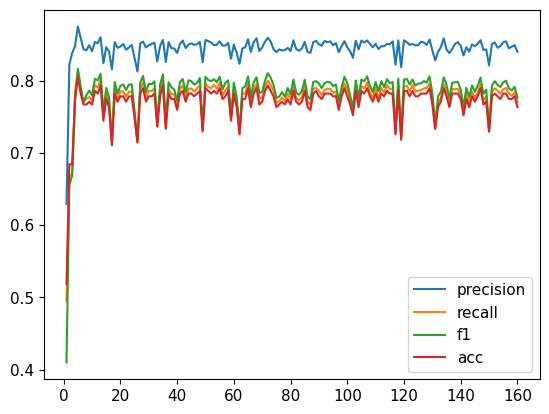

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(1, len(precision)+1), precision, label='precision')
plt.plot(np.arange(1, len(recall)+1), recall, label='recall')
plt.plot(np.arange(1, len(f1)+1), f1, label='f1')
plt.plot(np.arange(1, len(acc)+1), acc, label='acc')
plt.legend()
plt.savefig('../torch_rcnn_try/runs/run15_last_resnet/pr_re_f1_acc.png')


In [58]:
# get best epoch
best_epoch = np.argmax(recall) + 1
print(f'best epoch: {best_epoch}')
print(f'best f1: {f1[best_epoch-1]}')
print(f'best precision: {precision[best_epoch-1]}')
print(f'best recall: {recall[best_epoch-1]}')
print(f'best acc: {acc[best_epoch-1]}')

best epoch: 5
best f1: 0.8164
best precision: 0.8748
best recall: 0.8128
best acc: 0.8045


# YOLO

In [36]:
df = pd.read_csv('../yolov5/runs/euler/exp2/results.csv')
print(df.columns)

Index(['               epoch', '      train/box_loss', '      train/obj_loss',
       '      train/cls_loss', '   metrics/precision', '      metrics/recall',
       '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', '        val/box_loss',
       '        val/obj_loss', '        val/cls_loss', '               x/lr0',
       '               x/lr1', '               x/lr2'],
      dtype='object')


In [52]:
df2 = df.loc[df['     metrics/mAP_0.5'].idxmax()]

In [53]:
print(df2)

               epoch    68.000000
      train/box_loss     0.022324
      train/obj_loss     0.012427
      train/cls_loss     0.004871
   metrics/precision     0.849460
      metrics/recall     0.785710
     metrics/mAP_0.5     0.935480
metrics/mAP_0.5:0.95     0.807940
        val/box_loss     0.025456
        val/obj_loss     0.006051
        val/cls_loss     0.015247
               x/lr0     0.007789
               x/lr1     0.007789
               x/lr2     0.007789
Name: 68, dtype: float64
